In [1]:
import numpy as np
from copy import deepcopy
from buffer import MahjongBufferFrost2
import MahjongPy as mp
from wrapper import EnvMahjong2
import scipy.io as sio
from datetime import datetime
import time

now = datetime.now()
datetime_str = now.strftime("%Y%m%d-%H%M%S")

env = EnvMahjong2()

num_tile_type = env.matrix_feature_size[0]
num_each_tile = env.matrix_feature_size[1]
num_vf = env.vector_feature_size

memories = [MahjongBufferFrost2(size=1024, num_tile_type=num_tile_type, num_each_tile=num_each_tile,
                                num_vf=num_vf) for i in range(4)]


episode_start = 256
episode_savebuffer = 128
mu_size = 40

In [18]:
import pickle
dict = {"S":memories[1].S, "s":memories[1].s}

In [19]:
f = open("./test.pkl", 'wb')

In [20]:
pickle.dump(dict, f)

In [21]:
f = open("./test.pkl", 'rb')

In [22]:
data = pickle.load(f)

##  以下的代码可以让Agent读取保存的对局buffer， 如果comment掉就可以让Agent从头开始训练

In [2]:
# # example 
# for i in range(4):
#     buffer_path =  "./buffer/Agent{}".format(i) + "-MahjongBufferFrost220190521-155324.npz"
#     agents[i].memory.load(buffer_path)

##  以下的代码可以让Agent读取保存的网络， 如果comment掉就可以让Agent从头开始训练

In [3]:
# # example 
# for i in range(4):
#     model_path =  "../log/Agent{}".foramt(i) + "-20190501-175203-Game0/naiveAI.ckpt"
#     agents[i].nn.restore(model_path)
    

In [40]:
stop_action = mp.Action.Chi
Phases = ("P1_ACTION", "P2_ACTION", "P3_ACTION", "P4_ACTION", "P1_RESPONSE", "P2_RESPONSE", "P3_RESPONSE",
            "P4_RESPONSE", "P1_抢杠RESPONSE", "P2_抢杠RESPONSE", "P3_抢杠RESPONSE", "P4_抢杠RESPONSE",
            "P1_抢暗杠RESPONSE", "P2_抢暗杠RESPONSE", " P3_抢暗杠RESPONSE", " P4_抢暗杠RESPONSE", "GAME_OVER",
            "P1_DRAW, P2_DRAW, P3_DRAW, P4_DRAW")


In [61]:
stop_judge = 0
n_games = 1000000


process_time = 0
learn_time = 0 
select_time = 0
all_time = 0
play_time = 0
response_time = 0
copy_time = 0
done_time = 0

print("Start!")

for n in range(n_games):
    
    st_all =  time.time()
    
#     if n % 10000 == 0:
#         for i in range(4):
#             agents[i].nn.save(model_dir= "Agent{}-".format(i) + datetime_str + "-Game{}".format(n))  # save network parameters every 10000 episodes
    
#     for i in range(4):
#         if memories[i].tail % episode_savebuffer == 0:
#             memories[i].save("./buffer/Agent{}-".format(i) + "MahjongBufferFrost2_RanHoraPolicy_" + datetime_str + ".npz")
    
    print("\r Game {}".format(n), end='')

    episode_dones = [[], [], [], []]
    episode_states = [[], [], [], []]
    episode_rewards = [[], [], [], []]
    episode_actions = [[], [], [], []]
    episode_policies = [[], [], [], []]
    
    done = 0
#     policies = np.zeros([4,], dtype=np.int32)
    actions = np.zeros([4,], dtype=np.int32)
    rs = np.zeros([4,], dtype=np.float32)
    
    this_states = env.reset()  ## for all players
    
    next_aval_states = deepcopy(this_states)
    next_states = [[], [], [], []]
    
    step = 0
    
    while not done and step < 10000:

        who, what = env.who_do_what()
        
        st_play = time.time()
        ## make selection
        if what == "play":
            
            ######################## Draw a tile #####################
            
            next_states[who], r, done, _ = env.step_draw(playerNo=who)
            
            episode_dones[who].append(done)
            episode_states[who].append(this_states[who])
            episode_rewards[who].append(r)
            episode_actions[who].append(0)
            policy = np.zeros([mu_size,], dtype=np.float32)
            policy[0] += 1.
            episode_policies[who].append(policy) # only 1 available action (draw)
            
            this_states[who] = deepcopy(next_states[who])
            
            ###################### Play a tile #######################
            ###### 能和则和，能立直则立直 ############
            aval_actions = env.t.get_self_actions()
            good_actions = []
            
            for a in range(len(aval_actions)):
                if aval_actions[a].action == mp.Action.Riichi:
                    good_actions.append(a)

                if aval_actions[a].action == mp.Action.Tsumo:
                    good_actions.append(a)
            #######################################
#             st_process = time.time()

#             next_aval_states = env.get_aval_next_states(who)  ## for a single player
            
#             et_process = time.time()
#             process_time += et_process - st_process     
            
            st = time.time()
            if len(good_actions) > 0:
                good_actions = np.reshape(good_actions, [-1, ])
                
                a_in_good_as = np.random.choice(len(good_actions))
                policy = np.ones(len(good_actions), dtype=np.float32) / len(good_actions)
                
                action = good_actions[a_in_good_as]
                tmp = np.zeros([mu_size,], dtype=np.float32)
                tmp[good_actions] = policy
                policy = deepcopy(tmp)
            else:
                action = np.random.choice(len(aval_actions))
                policy = np.ones(len(aval_actions), dtype=np.float32) / len(aval_actions)
                # covert policy to vector (with padding)
                tmp = np.zeros([mu_size,], dtype=np.float32)
                tmp[:np.shape(policy)[0]] = policy
                policy = deepcopy(tmp)
            
            et = time.time()
            select_time += et - st
            
            aval_actions = env.t.get_self_actions()
            
            next_states[who], r, done, _ = env.step_play(action, playerNo=who)
                
            if aval_actions[actions[who]].action == stop_action:
                print("stop, player{}".format(who))
                print(undefined)
            
            next_states[who] = env.get_state_(who)
            
            episode_dones[who].append(done)
            episode_states[who].append(this_states[who])
            episode_rewards[who].append(r)
            episode_actions[who].append(action)
            episode_policies[who].append(policy) # only 1 available action (draw)
            
            this_states[who] = deepcopy(next_states[who])
            et_play = time.time()
            play_time += et_play - st_play
#             step += 2
        
        st_response = time.time()
        if what == "response":
            policies = [np.zeros([mu_size,], dtype=np.float32) for _ in range(4)]
            for i in range(4):
#                 st_process = time.time()
#                 next_aval_states = env.get_aval_next_states(i)
#                 et_process = time.time()
#                 process_time += et_process - st_process
                ######################## 能和则和，能立直则立直 ##############
                aval_actions = env.t.get_response_actions()
                good_actions = []
                
                for a in range(len(aval_actions)):
                    if aval_actions[a].action == mp.Action.Ron:
                        good_actions.append(a)

                    if aval_actions[a].action == mp.Action.ChanKan:
                        good_actions.append(a)

                    if aval_actions[a].action == mp.Action.ChanAnKan:
                        good_actions.append(a)
                ##########################################################
                st = time.time()
                if len(good_actions) > 0:
                    good_actions = np.reshape(good_actions, [-1, ])
                    a_in_good_as = np.random.choice(len(good_actions))
                    policies[i] = np.ones(len(good_actions), dtype=np.float32) / len(good_actions)
                    actions[i] = good_actions[a_in_good_as]
                    # covert policy to vector (with padding)
                    tmp = np.zeros([mu_size,], dtype=np.float32)
                    tmp[good_actions] = policies[i]
                    policies[i] = deepcopy(tmp)
                    
                else:
                    actions[i] = np.random.choice(len(aval_actions))
                    policies[i] = np.ones(len(aval_actions), dtype=np.float32) / len(aval_actions)
                    # covert policy to vector (with padding)
                    tmp = np.zeros([mu_size,], dtype=np.float32)
                    tmp[:np.shape(policies[i])[0]] = policies[i]
                    policies[i] = deepcopy(tmp)
                
                et = time.time()
                select_time += et - st
#                 print(Phases[env.t.get_phase()])

                aval_actions = env.t.get_response_actions()
    
                ######## stop test #############
                next_states[i], rs[i], done, _ = env.step_response(actions[i], playerNo=i)
                
                if aval_actions[actions[i]].action == stop_action:
                    chiplayerNo = i
                    stop_judge = 1
                    print('----- Player {} Chi -----'.format(chiplayerNo))
                    
                    for k in range(len(aval_actions[actions[i]].correspond_tiles)):
                        print(aval_actions[actions[i]].correspond_tiles[k].tile)
                    print(env.t.get_selected_action_tile().tile)
                    
                    
                ## Note: next_states is agent's prediction, but not the true one
            
            # table change after all players making actions
            if stop_judge:
                print(unf)
                fulus = env.t.players[chiplayerNo].fulus
                print('----- player {} fulu ------'.format(chiplayerNo))
                for k in range(len(fulus)):
                    for m in range(len(fulus[k].tiles)):
                        print(fulus[k].tiles[m].tile)
                print('==========================='.format(chiplayerNo))
                stop_judge = 0
            
            
            for i in range(4):
                next_states[i] = env.get_state_(i)
                episode_dones[i].append(done)
                episode_states[i].append(this_states[i])
                episode_rewards[i].append(rs[i])
                episode_actions[i].append(actions[i])
                episode_policies[i].append(policies[i]) # only 1 available action (draw)
        
            ## next step
            st_copy = time.time()
            for i in range(4):
                this_states[i] = deepcopy(next_states[i])
            et_copy = time.time()
            copy_time += et_copy - st_copy
            
            step += 1
        et_response = time.time()
        response_time += et_response - st_response
#         print("Game {}, step {}".format(n, step))
#         print(env.get_phase_text())
        
        if done:      
            st_done = time.time()
            final_score_change = env.get_final_score_change()
            for i in range(4):
                episode_states[i].append(env.get_state_(i))
                
                if len(episode_dones[i]) >= 1: # if not 1st turn end
                    episode_dones[i][-1] = 1
                
                #### Disable the following line if not care others
#                 episode_rewards[i][-1] = final_score_change[i]
                ##################################################
            
            if not np.max(final_score_change) == 0: ## score change
                for i in range(4):
                    memories[i].append_episode(episode_states[i],
                                               np.reshape(episode_rewards[i], [-1,]),
                                               np.reshape(episode_dones[i], [-1,]),
                                               np.reshape(episode_actions[i], [-1,]),
                                               np.reshape(episode_policies[i], [-1, 40]),
                                               weight=0)
#                     agents[i].remember_episode(episode_states[i], episode_rewards[i],
#                                                episode_dones[i], episode_policies[i], weight=1)
                print(' ')
                print(env.t.get_result().result_type, end='')
                print(": Totally {} steps".format(np.shape(episode_dones[0])[0]))
                
#                 with open("./Paipu/"+datetime.now().strftime("%Y%m%d-%H%M%S")+".txt", 'w+') as fp:
#                     fp.write(mp.GameLogToString(env.t.game_log).decode('GBK'))
#                     break
            else:
                if np.random.rand() < 0.0005: ## no score change
                    for i in range(4):
                        memories[i].append_episode(episode_states[i],
                                                   np.reshape(episode_rewards[i], [-1,]),
                                                   np.reshape(episode_dones[i], [-1,]),
                                                   np.reshape(episode_actions[i], [-1,]),
                                                   np.reshape(episode_policies[i], [-1, 40]),
                                                   weight=0)
                    print(' ')
                    print(env.t.get_result().result_type, end='')
                    print(": Totally {} steps".format(np.shape(episode_dones[0])[0]))
            
#             st = time.time()
#             for n_train in range(5):
#                 for i in range(4):
#                     agents[i].learn(env.symmetric_matrix_features, episode_start=episode_start, logging=True)
#             et = time.time()
#             learn2_time += et - st
            
#             et_done = time.time()
#             done_time += et_done - st_done
            
#             et_all = time.time()
#             all_time += et_all - st_all

# data = {"rons": env.final_score_changes}
# sio.savemat("./final_score_changes" + datetime_str + ".mat", data)


Start!
 Game 0----- Player 1 Chi -----
BaseTile._1m
BaseTile._2m
BaseTile._3m


NameError: name 'unf' is not defined

In [ ]:
# for i in range(4):
#     memories[i].save("./buffer/Agent{}-".format(i) + "MahjongBufferFrost2_RanHoraPolicy_228"  + ".npz")
    

In [63]:
print(all_time)
print(select_time)
print(learn_time)
print(play_time)
print(response_time)
print(process_time)
print(done_time)
print(copy_time)

0
0.002000570297241211
0
0.019994735717773438
0.0989370346069336
0
0
0.0009999275207519531


In [62]:
## Check tiles
for p in range(4):
    hand = env.t.players[p].hand
    print('----- player {} hand -----'.format(p))
    for k in range(len(hand)):
        print(hand[k].tile)
for p in range(4):
    fulus = env.t.players[p].fulus
    print('----- player {} fulu -----'.format(p))
    for k in range(len(fulus)):
        for m in range(len(fulus[k].tiles)):
            print(fulus[k].tiles[m].tile)

----- player 0 hand -----
BaseTile._2m
BaseTile._9m
BaseTile._1s
BaseTile._3s
BaseTile._4s
BaseTile._5s
BaseTile._3p
BaseTile._4p
BaseTile._4p
BaseTile._5p
BaseTile._7p
BaseTile.west
BaseTile.west
----- player 1 hand -----
BaseTile._1m
BaseTile._7m
BaseTile._7s
BaseTile._7s
BaseTile._8s
BaseTile._1p
BaseTile._2p
BaseTile._2p
BaseTile._5p
BaseTile._6p
BaseTile._9p
----- player 2 hand -----
BaseTile._3m
BaseTile._4m
BaseTile._8m
BaseTile._8m
BaseTile._6s
BaseTile._6s
BaseTile._8s
BaseTile._2p
BaseTile._5p
BaseTile.east
BaseTile.east
BaseTile.south
BaseTile.hatsu
----- player 3 hand -----
BaseTile._2m
BaseTile._6m
BaseTile._6m
BaseTile._8m
BaseTile._1s
BaseTile._5s
BaseTile._6s
BaseTile._9s
BaseTile._2p
BaseTile.haku
----- player 0 fulu -----
----- player 1 fulu -----
BaseTile._1m
BaseTile._2m
BaseTile._3m
----- player 2 fulu -----
----- player 3 fulu -----
BaseTile.chu
BaseTile.chu
BaseTile.chu


In [ ]:
env.t.DORA[0].tile

In [ ]:
this_states[0][0][:,28]

In [ ]:
env.t.get_selected_action_tile().tile

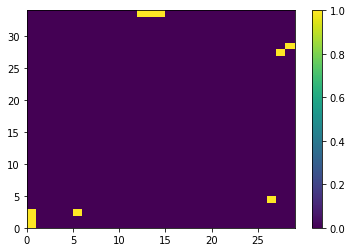

In [72]:
import matplotlib.pyplot as plt

playerNo = 1

plt.pcolor(env.get_state_(playerNo)[0][:,-29:])
plt.colorbar()
plt.show()


Action.Play


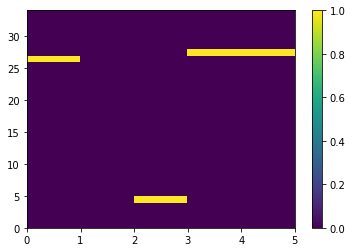

In [69]:
playerNo = 0
a = 10
plt.pcolor(env.get_next_state(a, playerNo)[0][:,-5:])
print(env.t.get_self_actions()[a].action)
plt.colorbar()
plt.show()

## Predict score (value function)

In [ ]:
mp.GameLogToString(env.t.game_log).decode('GBK')

In [ ]:
env.t.get_self_actions()